# Linear Regressions for HEAT , DROUGHT & HEAT+DROUGHT

In [1]:
import pandas as pd

performance_data = pd.read_csv('performance_data.csv')
submission_template = pd.read_csv('submission_template.csv')
weather_data = pd.read_csv('weather_data.csv')

## Transforming weather data into useful metrics

In [2]:
weather_data_grouped_mean = weather_data.groupby(by='ENV_ID').mean()
weather_data_grouped_std = weather_data.groupby(by='ENV_ID').std()
weather_data_grouped_mean.head()
weather_data_grouped_std.head()
weather_data_grouped = weather_data_grouped_mean.join(weather_data_grouped_std,lsuffix='_AVG',rsuffix='_STD')
weather_data_grouped = weather_data_grouped.drop('DAY_NUM_AVG',axis=1)
# weather_data_grouped.head()

## Joining performance and weather data

In [3]:
joined_df = performance_data.join(weather_data_grouped,on='ENV_ID')
joined_df.head()
joined_df.columns

heat_stress_df = joined_df[['HYBRID_ID','ENV_ID','YIELD','ENV_YIELD_MEAN','ENV_YIELD_STD','TMAX_AVG','TMAX_STD',
                            'TMIN_AVG','TMIN_STD','DAYL_AVG','DAYL_STD',
                           'SRAD_AVG','SRAD_STD']]
drought_stress_df = joined_df[['HYBRID_ID','ENV_ID','YIELD','ENV_YIELD_MEAN','ENV_YIELD_STD','IRRIGATION','PREC_AVG','PREC_STD','KSAT',
                              'SWE_AVG','SWE_STD','VP_AVG','VP_STD','AWC']]

trainheat_df=heat_stress_df.loc[:10000]
testheat_df=heat_stress_df.loc[10000:]
testheat_df=testheat_df[['HYBRID_ID','ENV_ID','YIELD','ENV_YIELD_MEAN','TMAX_AVG', 'TMAX_STD', 'TMIN_AVG', 'TMIN_STD', 'DAYL_AVG', 'DAYL_STD',
       'SRAD_AVG', 'SRAD_STD']]


## First Linear Regression Test

In [4]:
import statsmodels.api as sm

features_=['TMAX_AVG','TMAX_STD','TMIN_AVG','TMIN_STD','DAYL_AVG','DAYL_STD','SRAD_AVG','SRAD_STD']
X = trainheat_df[features_]
y = trainheat_df["ENV_YIELD_MEAN"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
# model.summary()

# print(model.params)
print(model.summary2())
coeff_df=pd.DataFrame(model.params)
print(coeff_df)
tc=coeff_df.transpose()
tc.columns


                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.990     
Dependent Variable: ENV_YIELD_MEAN   AIC:                75882.0763
Date:               2018-12-01 19:11 BIC:                75939.7598
No. Observations:   10001            Log-Likelihood:     -37933.   
Df Model:           8                F-statistic:        1.193e+05 
Df Residuals:       9993             Prob (F-statistic): 0.00      
R-squared:          0.990            Scale:              115.44    
---------------------------------------------------------------------
            Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
---------------------------------------------------------------------
TMAX_AVG   -0.7617     0.2642    -2.8826   0.0040   -1.2796   -0.2437
TMAX_STD    4.8163     0.4639    10.3825   0.0000    3.9070    5.7256
TMIN_AVG   11.2381     0.3121    36.0131   0.0000   10.6264   11.8498
TMIN_STD    2.7699     0.3543     7.8171   0.0000    2

Index(['TMAX_AVG', 'TMAX_STD', 'TMIN_AVG', 'TMIN_STD', 'DAYL_AVG', 'DAYL_STD',
       'SRAD_AVG', 'SRAD_STD'],
      dtype='object')

In [5]:

coeff_=tc['TMAX_AVG']
testheat_df['TMAX_AVG']=testheat_df['TMAX_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['TMAX_STD']
testheat_df['TMAX_STD']=testheat_df['TMAX_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['TMIN_AVG']
testheat_df['TMIN_AVG']=testheat_df['TMIN_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['TMIN_STD']
testheat_df['TMIN_STD']=testheat_df['TMIN_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['DAYL_AVG']
testheat_df['DAYL_AVG']=testheat_df['DAYL_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['DAYL_STD']
testheat_df['DAYL_STD']=testheat_df['DAYL_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['SRAD_AVG']
testheat_df['SRAD_AVG']=testheat_df['SRAD_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['SRAD_STD']
testheat_df['SRAD_STD']=testheat_df['SRAD_STD'].apply (lambda x: coeff_ * x )


In [6]:

testheatreg_df=testheat_df[['TMAX_AVG', 'TMAX_STD', 'TMIN_AVG', 'TMIN_STD', 'DAYL_AVG', 'DAYL_STD',
       'SRAD_AVG', 'SRAD_STD']]
real_=testheat_df["ENV_YIELD_MEAN"]
regress_=[]
regress_=list(testheatreg_df.sum(1))
regress_=pd.DataFrame(regress_, columns=['YIELDREG'])
real_=pd.DataFrame(list(real_), columns=['YIELDREG'])
# print(regress_)
# print(real_)
error_=(real_-regress_)**2
# print(error_)
print('sqmeanerror',error_.mean()**0.5)
print('sqstderror',error_.std()**0.5)


sqmeanerror YIELDREG    24.743205
dtype: float64
sqstderror YIELDREG    42.383336
dtype: float64


## Grouping by Env to create new Linear Regression by Enviroment instead of Crop
### The previous linear Regression is not very representative as it repeats the same information for every Hybrid with the same enviroment data, instead the next 3 set of linear regressions look to predict the Enviroment Yield by establishing coefficients that can be applied to any particular set of conditions in any enviroment

In [7]:
heat_stress_env = joined_df[['ENV_ID','ENV_YIELD_MEAN','ENV_YIELD_STD','TMAX_AVG','TMAX_STD',
                            'TMIN_AVG','TMIN_STD','DAYL_AVG','DAYL_STD',
                           'SRAD_AVG','SRAD_STD']]
drought_stress_env = joined_df[['ENV_ID','ENV_YIELD_MEAN','ENV_YIELD_STD','IRRIGATION','PREC_AVG','PREC_STD','KSAT',
                              'SWE_AVG','SWE_STD','VP_AVG','VP_STD','AWC']]



In [8]:
#Converting dataframes to create linear regressions based only on enviroments

heat_stress_env=heat_stress_env.drop_duplicates(subset=None, keep='first', inplace=False)
heat_stress_env=heat_stress_env.reset_index(level=0, drop=True)
# print(heat_stress_env)
print('HeatStressLen>',heat_stress_env.index)

drought_stress_env=drought_stress_env.drop_duplicates(subset=None, keep='first', inplace=False)
drought_stress_env=drought_stress_env.reset_index(level=0, drop=True)
# print(heat_stress_env)
print('DroughtStressLen>',drought_stress_env.index)

HeatStressLen> RangeIndex(start=0, stop=1560, step=1)
DroughtStressLen> RangeIndex(start=0, stop=1560, step=1)


# HEAT LR

In [9]:
trainheat_env=heat_stress_env.loc[:400]
testheat_env=heat_stress_env.loc[401:]
testheat_env=testheat_env[['ENV_ID','ENV_YIELD_MEAN','TMAX_AVG', 'TMAX_STD', 'TMIN_AVG', 'TMIN_STD', 'DAYL_AVG', 'DAYL_STD',
       'SRAD_AVG', 'SRAD_STD']]

features_=['TMAX_AVG','TMAX_STD','TMIN_AVG','TMIN_STD','DAYL_AVG','DAYL_STD','SRAD_AVG','SRAD_STD']
X = trainheat_env[features_]
y = trainheat_env["ENV_YIELD_MEAN"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary2())

coeff_df=pd.DataFrame(model.params)
print(coeff_df)
tc=coeff_df.transpose()
tc.columns


                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.982    
Dependent Variable: ENV_YIELD_MEAN   AIC:                3308.6060
Date:               2018-12-01 19:17 BIC:                3340.5577
No. Observations:   401              Log-Likelihood:     -1646.3  
Df Model:           8                F-statistic:        2762.    
Df Residuals:       393              Prob (F-statistic): 0.00     
R-squared:          0.983            Scale:              219.92   
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
TMAX_AVG   -0.8813     1.4884   -0.5921   0.5541   -3.8076    2.0450
TMAX_STD    4.6596     2.5594    1.8206   0.0694   -0.3722    9.6914
TMIN_AVG    8.3948     2.0279    4.1396   0.0000    4.4079   12.3817
TMIN_STD    2.1579     2.1022    1.0265   0.3053   -1.9750    6.2908

Index(['TMAX_AVG', 'TMAX_STD', 'TMIN_AVG', 'TMIN_STD', 'DAYL_AVG', 'DAYL_STD',
       'SRAD_AVG', 'SRAD_STD'],
      dtype='object')

In [10]:
#Test coefficients with test data

coeff_=tc['TMAX_AVG']
testheat_env['TMAX_AVG']=testheat_env['TMAX_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['TMAX_STD']
testheat_env['TMAX_STD']=testheat_env['TMAX_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['TMIN_AVG']
testheat_env['TMIN_AVG']=testheat_env['TMIN_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['TMIN_STD']
testheat_env['TMIN_STD']=testheat_env['TMIN_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['DAYL_AVG']
testheat_env['DAYL_AVG']=testheat_env['DAYL_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['DAYL_STD']
testheat_env['DAYL_STD']=testheat_env['DAYL_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['SRAD_AVG']
testheat_env['SRAD_AVG']=testheat_env['SRAD_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['SRAD_STD']
testheat_env['SRAD_STD']=testheat_env['SRAD_STD'].apply (lambda x: coeff_ * x )

testheatreg_env=testheat_env[['TMAX_AVG', 'TMAX_STD', 'TMIN_AVG', 'TMIN_STD', 'DAYL_AVG', 'DAYL_STD',
       'SRAD_AVG', 'SRAD_STD']]
real_=testheat_env["ENV_YIELD_MEAN"]
regress_=[]
regress_=list(testheatreg_env.sum(1))
regress_=pd.DataFrame(regress_, columns=['YIELDREG'])
real_=pd.DataFrame(list(real_), columns=['YIELDREG'])
# print(regress_)
# print(real_)
error_=(real_-regress_)**2
# print(error_)
print('sqmeanerror',error_.mean()**0.5)
print('sqstderror',error_.std()**0.5)


sqmeanerror YIELDREG    37.84038
dtype: float64
sqstderror YIELDREG    56.95416
dtype: float64


### SQMEAN ERROR serves as a measure of accuracy of the predicted yield in the test data, each iteration aims to reduce this value by considering the coefficients impact, the p value (less than 0.25) and the multicolinearity of the model

In [11]:
#Taking Out DAYL as P Value is too large
trainheat_env=heat_stress_env.loc[:400]
testheat_env=heat_stress_env.loc[401:]
testheat_env=testheat_env[['ENV_ID','ENV_YIELD_MEAN','TMAX_AVG', 'TMAX_STD', 'TMIN_AVG', 'TMIN_STD', 'DAYL_AVG', 'DAYL_STD',
       'SRAD_AVG', 'SRAD_STD']]

features_=['TMAX_AVG','TMAX_STD','TMIN_AVG','TMIN_STD','SRAD_AVG','SRAD_STD']
X = trainheat_env[features_]
y = trainheat_env["ENV_YIELD_MEAN"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary2())

coeff_df=pd.DataFrame(model.params)
print(coeff_df)
tc=coeff_df.transpose()
tc.columns


                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.982    
Dependent Variable: ENV_YIELD_MEAN   AIC:                3304.8131
Date:               2018-12-01 19:17 BIC:                3328.7769
No. Observations:   401              Log-Likelihood:     -1646.4  
Df Model:           6                F-statistic:        3700.    
Df Residuals:       395              Prob (F-statistic): 0.00     
R-squared:          0.983            Scale:              218.92   
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
TMAX_AVG   -0.4855     1.1132   -0.4362   0.6630   -2.6741    1.7030
TMAX_STD    5.0057     2.1721    2.3045   0.0217    0.7354    9.2760
TMIN_AVG    7.6073     1.0241    7.4281   0.0000    5.5939    9.6207
TMIN_STD    1.8440     1.9743    0.9340   0.3509   -2.0374    5.7255

Index(['TMAX_AVG', 'TMAX_STD', 'TMIN_AVG', 'TMIN_STD', 'SRAD_AVG', 'SRAD_STD'], dtype='object')

In [12]:
#Test coefficients with test data

coeff_=tc['TMAX_AVG']
testheat_env['TMAX_AVG']=testheat_env['TMAX_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['TMAX_STD']
testheat_env['TMAX_STD']=testheat_env['TMAX_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['TMIN_AVG']
testheat_env['TMIN_AVG']=testheat_env['TMIN_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['TMIN_STD']
testheat_env['TMIN_STD']=testheat_env['TMIN_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['SRAD_AVG']
testheat_env['SRAD_AVG']=testheat_env['SRAD_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['SRAD_STD']
testheat_env['SRAD_STD']=testheat_env['SRAD_STD'].apply (lambda x: coeff_ * x )


testheatreg_env=testheat_env[['TMAX_AVG', 'TMAX_STD', 'TMIN_AVG', 'TMIN_STD',
       'SRAD_AVG', 'SRAD_STD']]
real_=testheat_env["ENV_YIELD_MEAN"]
regress_=[]
regress_=list(testheatreg_env.sum(1))
regress_=pd.DataFrame(regress_, columns=['YIELDREG'])
real_=pd.DataFrame(list(real_), columns=['YIELDREG'])
# print(regress_)
# print(real_)
error_=(real_-regress_)**2
# print(error_)
print('sqmeanerror',error_.mean()**0.5)
print('sqstderror',error_.std()**0.5)

sqmeanerror YIELDREG    37.799961
dtype: float64
sqstderror YIELDREG    56.677163
dtype: float64


In [13]:
#Taking Out SRAD due to multicolinearity and no improvement in previous iteration
trainheat_env=heat_stress_env.loc[:400]
testheat_env=heat_stress_env.loc[401:]
testheat_env=testheat_env[['ENV_ID','ENV_YIELD_MEAN','TMAX_AVG', 'TMAX_STD', 'TMIN_AVG', 'TMIN_STD', 'DAYL_AVG', 'DAYL_STD',
       'SRAD_AVG', 'SRAD_STD']]



features_=['TMAX_AVG','TMAX_STD','TMIN_AVG','TMIN_STD']
X = trainheat_env[features_]
y = trainheat_env["ENV_YIELD_MEAN"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary2())

coeff_df=pd.DataFrame(model.params)
print(coeff_df)
tc=coeff_df.transpose()
tc.columns


                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.982    
Dependent Variable: ENV_YIELD_MEAN   AIC:                3311.7646
Date:               2018-12-01 19:17 BIC:                3327.7404
No. Observations:   401              Log-Likelihood:     -1651.9  
Df Model:           4                F-statistic:        5425.    
Df Residuals:       397              Prob (F-statistic): 0.00     
R-squared:          0.982            Scale:              223.85   
--------------------------------------------------------------------
              Coef.    Std.Err.     t      P>|t|     [0.025   0.975]
--------------------------------------------------------------------
TMAX_AVG      2.1037     0.5767   3.6478   0.0003    0.9699   3.2374
TMAX_STD      2.1553     1.9356   1.1135   0.2662   -1.6500   5.9606
TMIN_AVG      5.7322     0.8525   6.7239   0.0000    4.0562   7.4082
TMIN_STD      4.1380     1.8688   2.2142   0.0274    0.4639   7.8120

Index(['TMAX_AVG', 'TMAX_STD', 'TMIN_AVG', 'TMIN_STD'], dtype='object')

In [14]:
#Test coefficients with test data

coeff_=tc['TMAX_AVG']
testheat_env['TMAX_AVG']=testheat_env['TMAX_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['TMAX_STD']
testheat_env['TMAX_STD']=testheat_env['TMAX_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['TMIN_AVG']
testheat_env['TMIN_AVG']=testheat_env['TMIN_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['TMIN_STD']
testheat_env['TMIN_STD']=testheat_env['TMIN_STD'].apply (lambda x: coeff_ * x )

testheatreg_env=testheat_env[['TMAX_AVG', 'TMAX_STD', 'TMIN_AVG', 'TMIN_STD']]
real_=testheat_env["ENV_YIELD_MEAN"]
regress_=[]
regress_=list(testheatreg_env.sum(1))
regress_=pd.DataFrame(regress_, columns=['YIELDREG'])
real_=pd.DataFrame(list(real_), columns=['YIELDREG'])
# print(regress_)
# print(real_)
error_=(real_-regress_)**2
# print(error_)
print('sqmeanerror',error_.mean()**0.5)
print('sqstderror',error_.std()**0.5)
heat_error_=error_.mean()**0.5
hreal_=real_
hregress_=regress_


sqmeanerror YIELDREG    37.473368
dtype: float64
sqstderror YIELDREG    56.642275
dtype: float64


## Coefficients used for Heat Linear Regression Prediction of Enviroment Yield:

In [15]:
heat_coeff=tc
print(heat_error_)
heat_coeff

YIELDREG    37.473368
dtype: float64


,TMAX_AVG,TMAX_STD,TMIN_AVG,TMIN_STD
0,2.103662,2.155283,5.732214,4.137954


Heat, Actual vs Regression Comparison


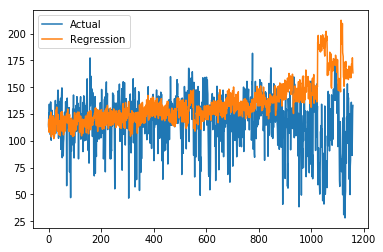

In [17]:
hrvsa_=pd.concat([hreal_,hregress_], axis=1, sort=False)
hrvsa_.columns=["Actual","Regression"]
print("Heat, Actual vs Regression Comparison")
hplot_=hrvsa_.plot()

# DROUGHT LR

In [18]:
#DROUGHT

traindr_env=drought_stress_env.loc[:400]
testdr_env=drought_stress_env.loc[401:]
testdr_env=testdr_env[['ENV_ID','ENV_YIELD_MEAN','PREC_AVG','PREC_STD','KSAT',
                              'SWE_AVG','SWE_STD','VP_AVG','VP_STD','AWC']]


features_=['PREC_AVG','PREC_STD','KSAT',
                              'SWE_AVG','SWE_STD','VP_AVG','VP_STD','AWC']
X = traindr_env[features_]
y = traindr_env["ENV_YIELD_MEAN"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary2())

coeff_df=pd.DataFrame(model.params)
print(coeff_df)
tc=coeff_df.transpose()
tc.columns


                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.981    
Dependent Variable: ENV_YIELD_MEAN   AIC:                3334.7336
Date:               2018-12-01 19:18 BIC:                3366.6853
No. Observations:   401              Log-Likelihood:     -1659.4  
Df Model:           8                F-statistic:        2585.    
Df Residuals:       393              Prob (F-statistic): 0.00     
R-squared:          0.981            Scale:              234.73   
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
PREC_AVG   -4.7865     3.0649   -1.5617   0.1192   -10.8121   1.2391
PREC_STD    4.4281     1.0583    4.1843   0.0000     2.3476   6.5087
KSAT        3.0154     0.4163    7.2433   0.0000     2.1969   3.8338
SWE_AVG    -0.6899     0.3668   -1.8806   0.0608    -1.4111   0.0313

Index(['PREC_AVG', 'PREC_STD', 'KSAT', 'SWE_AVG', 'SWE_STD', 'VP_AVG',
       'VP_STD', 'AWC'],
      dtype='object')

In [19]:
traindr_env=drought_stress_env.loc[:400]
testdr_env=drought_stress_env.loc[401:]
testdr_env=testdr_env[['ENV_ID','ENV_YIELD_MEAN','PREC_AVG','PREC_STD','KSAT',
                              'SWE_AVG','SWE_STD','VP_AVG','VP_STD','AWC']]

#REMOVING SWE due to p value and low coeff

features_=['PREC_AVG','PREC_STD','KSAT','VP_AVG','VP_STD','AWC']
X = traindr_env[features_]
y = traindr_env["ENV_YIELD_MEAN"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary2())

coeff_df=pd.DataFrame(model.params)
print(coeff_df)
tc=coeff_df.transpose()
tc.columns


                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.981    
Dependent Variable: ENV_YIELD_MEAN   AIC:                3342.2176
Date:               2018-12-01 19:18 BIC:                3366.1814
No. Observations:   401              Log-Likelihood:     -1665.1  
Df Model:           6                F-statistic:        3364.    
Df Residuals:       395              Prob (F-statistic): 0.00     
R-squared:          0.981            Scale:              240.32   
-------------------------------------------------------------------
              Coef.    Std.Err.     t     P>|t|    [0.025    0.975]
-------------------------------------------------------------------
PREC_AVG     -12.1006    1.8652  -6.4875  0.0000  -15.7676  -8.4336
PREC_STD       5.8866    0.9426   6.2449  0.0000    4.0334   7.7398
KSAT           2.8337    0.4177   6.7839  0.0000    2.0125   3.6549
VP_AVG         0.1073    0.0133   8.0929  0.0000    0.0813   0.1334
VP_STD

Index(['PREC_AVG', 'PREC_STD', 'KSAT', 'VP_AVG', 'VP_STD', 'AWC'], dtype='object')

In [20]:
#Test coefficients with test data


'PREC_AVG','PREC_STD','KSAT','VP_AVG','VP_STD','AWC'

coeff_=tc['PREC_AVG']
testdr_env['PREC_AVG']=testdr_env['PREC_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['PREC_STD']
testdr_env['PREC_STD']=testdr_env['PREC_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['KSAT']
testdr_env['KSAT']=testdr_env['KSAT'].apply (lambda x: coeff_ * x )
coeff_=tc['VP_AVG']
testdr_env['VP_AVG']=testdr_env['VP_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['VP_STD']
testdr_env['VP_STD']=testdr_env['VP_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['AWC']
testdr_env['AWC']=testdr_env['AWC'].apply (lambda x: coeff_ * x )


testdrreg_env=testdr_env[['PREC_AVG','PREC_STD','KSAT','VP_AVG','VP_STD','AWC']]
real_=testdr_env["ENV_YIELD_MEAN"]
regress_=[]
regress_=list(testdrreg_env.sum(1))
regress_=pd.DataFrame(regress_, columns=['YIELDREG'])
real_=pd.DataFrame(list(real_), columns=['YIELDREG'])
# print(regress_)
# print(real_)
error_=(real_-regress_)**2
# print(error_)
print('sqmeanerror',error_.mean()**0.5)
print('sqstderror',error_.std()**0.5)


sqmeanerror YIELDREG    38.425607
dtype: float64
sqstderror YIELDREG    62.835857
dtype: float64


In [21]:
traindr_env=drought_stress_env.loc[:400]
testdr_env=drought_stress_env.loc[401:]
testdr_env=testdr_env[['ENV_ID','ENV_YIELD_MEAN','PREC_AVG','PREC_STD','KSAT',
                              'SWE_AVG','SWE_STD','VP_AVG','VP_STD','AWC']]

#REMOVING VP due to low coeff

features_=['PREC_AVG','PREC_STD','KSAT','AWC']
X = traindr_env[features_]
y = traindr_env["ENV_YIELD_MEAN"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary2())

coeff_df=pd.DataFrame(model.params)
print(coeff_df)
tc=coeff_df.transpose()
tc.columns

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.977    
Dependent Variable: ENV_YIELD_MEAN   AIC:                3403.6910
Date:               2018-12-01 19:18 BIC:                3419.6668
No. Observations:   401              Log-Likelihood:     -1697.8  
Df Model:           4                F-statistic:        4293.    
Df Residuals:       397              Prob (F-statistic): 0.00     
R-squared:          0.977            Scale:              281.52   
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
PREC_AVG   -3.4617     1.4986   -2.3099   0.0214   -6.4079   -0.5155
PREC_STD    5.7836     0.8061    7.1748   0.0000    4.1989    7.3684
KSAT        3.5621     0.4047    8.8025   0.0000    2.7665    4.3576
AWC         3.1812     0.1914   16.6218   0.0000    2.8049    3.5574

Index(['PREC_AVG', 'PREC_STD', 'KSAT', 'AWC'], dtype='object')

In [22]:
#Test coefficients with test data


# 'PREC_AVG','PREC_STD','KSAT','VP_AVG','VP_STD','AWC'

coeff_=tc['PREC_AVG']
testdr_env['PREC_AVG']=testdr_env['PREC_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['PREC_STD']
testdr_env['PREC_STD']=testdr_env['PREC_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['KSAT']
testdr_env['KSAT']=testdr_env['KSAT'].apply (lambda x: coeff_ * x )


coeff_=tc['AWC']
testdr_env['AWC']=testdr_env['AWC'].apply (lambda x: coeff_ * x )


testdrreg_env=testdr_env[['PREC_AVG','PREC_STD','KSAT','AWC']]
real_=testdr_env["ENV_YIELD_MEAN"]
regress_=[]
regress_=list(testdrreg_env.sum(1))
regress_=pd.DataFrame(regress_, columns=['YIELDREG'])
real_=pd.DataFrame(list(real_), columns=['YIELDREG'])
# print(regress_)
# print(real_)
error_=(real_-regress_)**2
# print(error_)
print('sqmeanerror',error_.mean()**0.5)
print('sqstderror',error_.std()**0.5)
drought_sqerror_=error_.mean()**0.5
dreal_=real_
dregress_=regress_


sqmeanerror YIELDREG    26.160086
dtype: float64
sqstderror YIELDREG    33.444837
dtype: float64


## Coefficients used for Drought Linear Regression Prediction of Enviroment Yield:

In [23]:
drought_coeff=tc
print("Drought SqMeanError",drought_sqerror_)
drought_coeff

Drought SqMeanError YIELDREG    26.160086
dtype: float64


,PREC_AVG,PREC_STD,KSAT,AWC
0,-3.461698,5.783615,3.56207,3.181174


Drought, Actual vs Regression Comparison


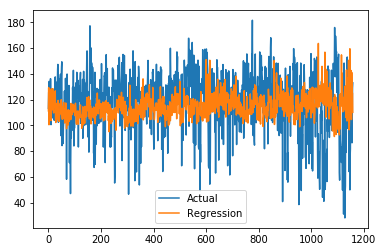

In [24]:
drvsa_=pd.concat([dreal_,dregress_], axis=1, sort=False)
drvsa_.columns=["Actual","Regression"]
print("Drought, Actual vs Regression Comparison")
dplot_=drvsa_.plot()

# HEAT+DROUGHT LR

In [25]:
hd_env = joined_df[['ENV_ID','ENV_YIELD_MEAN','ENV_YIELD_STD','TMAX_AVG','TMAX_STD',
                            'TMIN_AVG','TMIN_STD','DAYL_AVG','DAYL_STD',
                           'SRAD_AVG','SRAD_STD','IRRIGATION','PREC_AVG','PREC_STD','KSAT',
                              'SWE_AVG','SWE_STD','VP_AVG','VP_STD','AWC']]

#Converting dataframes to create linear regressions based only on enviroments

hd_env=hd_env.drop_duplicates(subset=None, keep='first', inplace=False)
hd_env=hd_env.reset_index(level=0, drop=True)

print('HeatDroughtStressLen>',hd_env.index)



HeatDroughtStressLen> RangeIndex(start=0, stop=1560, step=1)


In [26]:
trainhd_env=hd_env.loc[:400]
testhd_env=hd_env.loc[401:]
testhd_env=testhd_env[['ENV_ID','ENV_YIELD_MEAN','ENV_YIELD_STD','TMAX_AVG','TMAX_STD',
                            'TMIN_AVG','TMIN_STD','DAYL_AVG','DAYL_STD',
                           'SRAD_AVG','SRAD_STD','IRRIGATION','PREC_AVG','PREC_STD','KSAT',
                              'SWE_AVG','SWE_STD','VP_AVG','VP_STD','AWC']]


features_=['TMAX_AVG','TMAX_STD','TMIN_AVG','TMIN_STD','DAYL_AVG','DAYL_STD',
                           'SRAD_AVG','SRAD_STD','PREC_AVG','PREC_STD','KSAT',
                              'SWE_AVG','SWE_STD','VP_AVG','VP_STD','AWC']
X = trainhd_env[features_]
y = trainhd_env["ENV_YIELD_MEAN"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary2())

coeff_df=pd.DataFrame(model.params)
print(coeff_df)
tc=coeff_df.transpose()
tc.columns


                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.983    
Dependent Variable: ENV_YIELD_MEAN   AIC:                3292.3949
Date:               2018-12-01 19:19 BIC:                3356.2983
No. Observations:   401              Log-Likelihood:     -1630.2  
Df Model:           16               F-statistic:        1468.    
Df Residuals:       385              Prob (F-statistic): 0.00     
R-squared:          0.984            Scale:              207.16   
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
TMAX_AVG   -2.0449     1.5775   -1.2963   0.1956   -5.1465    1.0567
TMAX_STD    6.2399     3.2508    1.9195   0.0557   -0.1516   12.6315
TMIN_AVG   14.6750     2.8653    5.1217   0.0000    9.0415   20.3085
TMIN_STD    5.7865     2.5251    2.2915   0.0225    0.8217   10.7513

Index(['TMAX_AVG', 'TMAX_STD', 'TMIN_AVG', 'TMIN_STD', 'DAYL_AVG', 'DAYL_STD',
       'SRAD_AVG', 'SRAD_STD', 'PREC_AVG', 'PREC_STD', 'KSAT', 'SWE_AVG',
       'SWE_STD', 'VP_AVG', 'VP_STD', 'AWC'],
      dtype='object')

In [27]:
#REMOVING DAYL due to high Pvalue

trainhd_env=hd_env.loc[:400]
testhd_env=hd_env.loc[401:]
testhd_env=testhd_env[['ENV_ID','ENV_YIELD_MEAN','ENV_YIELD_STD','TMAX_AVG','TMAX_STD',
                            'TMIN_AVG','TMIN_STD','DAYL_AVG','DAYL_STD',
                           'SRAD_AVG','SRAD_STD','IRRIGATION','PREC_AVG','PREC_STD','KSAT',
                              'SWE_AVG','SWE_STD','VP_AVG','VP_STD','AWC']]


features_=['TMAX_AVG','TMAX_STD','TMIN_AVG','TMIN_STD',
                           'SRAD_AVG','SRAD_STD','PREC_AVG','PREC_STD','KSAT',
                              'SWE_AVG','SWE_STD','VP_AVG','VP_STD']
X = trainhd_env[features_]
y = trainhd_env["ENV_YIELD_MEAN"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary2())

coeff_df=pd.DataFrame(model.params)
print(coeff_df)
tc=coeff_df.transpose()
tc.columns


                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.983    
Dependent Variable: ENV_YIELD_MEAN   AIC:                3286.9545
Date:               2018-12-01 19:19 BIC:                3338.8760
No. Observations:   401              Log-Likelihood:     -1630.5  
Df Model:           13               F-statistic:        1818.    
Df Residuals:       388              Prob (F-statistic): 0.00     
R-squared:          0.984            Scale:              205.85   
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
TMAX_AVG   -1.7831     1.3345   -1.3361   0.1823   -4.4069    0.8407
TMAX_STD    7.4202     2.6166    2.8358   0.0048    2.2757   12.5647
TMIN_AVG   14.4521     2.5224    5.7295   0.0000    9.4929   19.4114
TMIN_STD    5.2726     2.4149    2.1834   0.0296    0.5247   10.0206

Index(['TMAX_AVG', 'TMAX_STD', 'TMIN_AVG', 'TMIN_STD', 'SRAD_AVG', 'SRAD_STD',
       'PREC_AVG', 'PREC_STD', 'KSAT', 'SWE_AVG', 'SWE_STD', 'VP_AVG',
       'VP_STD'],
      dtype='object')

In [28]:
#Test coefficients with test data

coeff_=tc['TMAX_AVG']
testhd_env['TMAX_AVG']=testhd_env['TMAX_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['TMAX_STD']
testhd_env['TMAX_STD']=testhd_env['TMAX_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['TMIN_AVG']
testhd_env['TMIN_AVG']=testhd_env['TMIN_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['TMIN_STD']
testhd_env['TMIN_STD']=testhd_env['TMIN_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['SRAD_AVG']
testhd_env['SRAD_AVG']=testhd_env['SRAD_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['SRAD_STD']
testhd_env['SRAD_STD']=testhd_env['SRAD_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['PREC_AVG']
testhd_env['PREC_AVG']=testhd_env['PREC_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['PREC_STD']
testhd_env['PREC_STD']=testhd_env['PREC_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['KSAT']
testhd_env['KSAT']=testhd_env['KSAT'].apply (lambda x: coeff_ * x )
coeff_=tc['VP_AVG']
testhd_env['VP_AVG']=testhd_env['VP_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['VP_STD']
testhd_env['VP_STD']=testhd_env['VP_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['SWE_AVG']
testhd_env['SWE_AVG']=testhd_env['SWE_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['SWE_STD']
testhd_env['SWE_STD']=testhd_env['SWE_STD'].apply (lambda x: coeff_ * x )


testhdreg_env=testhd_env[['TMAX_AVG','TMAX_STD','TMIN_AVG','TMIN_STD',
                           'SRAD_AVG','SRAD_STD','PREC_AVG','PREC_STD','KSAT',
                              'SWE_AVG','SWE_STD','VP_AVG','VP_STD']]


real_=testhd_env["ENV_YIELD_MEAN"]
regress_=[]
regress_=list(testhdreg_env.sum(1))
regress_=pd.DataFrame(regress_, columns=['YIELDREG'])
real_=pd.DataFrame(list(real_), columns=['YIELDREG'])

error_=(real_-regress_)**2

print('sqmeanerror',error_.mean()**0.5)
print('sqstderror',error_.std()**0.5)


sqmeanerror YIELDREG    30.536238
dtype: float64
sqstderror YIELDREG    45.364484
dtype: float64


In [29]:
#REMOVING KSAT due to high Pvalue

trainhd_env=hd_env.loc[:400]
testhd_env=hd_env.loc[401:]
testhd_env=testhd_env[['ENV_ID','ENV_YIELD_MEAN','ENV_YIELD_STD','TMAX_AVG','TMAX_STD',
                            'TMIN_AVG','TMIN_STD','DAYL_AVG','DAYL_STD',
                           'SRAD_AVG','SRAD_STD','IRRIGATION','PREC_AVG','PREC_STD','KSAT',
                              'SWE_AVG','SWE_STD','VP_AVG','VP_STD','AWC']]


features_=['TMAX_AVG','TMAX_STD','TMIN_AVG','TMIN_STD',
                           'SRAD_AVG','SRAD_STD','PREC_AVG','PREC_STD','SWE_AVG','SWE_STD','VP_AVG','VP_STD']
X = trainhd_env[features_]
y = trainhd_env["ENV_YIELD_MEAN"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary2())

coeff_df=pd.DataFrame(model.params)
print(coeff_df)
tc=coeff_df.transpose()
hdelements_=tc.columns
tc.columns


                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.983    
Dependent Variable: ENV_YIELD_MEAN   AIC:                3286.5338
Date:               2018-12-01 19:19 BIC:                3334.4613
No. Observations:   401              Log-Likelihood:     -1631.3  
Df Model:           12               F-statistic:        1967.    
Df Residuals:       389              Prob (F-statistic): 0.00     
R-squared:          0.984            Scale:              206.13   
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
TMAX_AVG   -1.4537     1.3086   -1.1109   0.2673   -4.0264    1.1191
TMAX_STD    7.6210     2.6134    2.9162   0.0037    2.4829   12.7590
TMIN_AVG   14.1189     2.5097    5.6257   0.0000    9.1846   19.0531
TMIN_STD    4.9720     2.4043    2.0680   0.0393    0.2450    9.6990

Index(['TMAX_AVG', 'TMAX_STD', 'TMIN_AVG', 'TMIN_STD', 'SRAD_AVG', 'SRAD_STD',
       'PREC_AVG', 'PREC_STD', 'SWE_AVG', 'SWE_STD', 'VP_AVG', 'VP_STD'],
      dtype='object')

In [30]:
#Test coefficients with test data

coeff_=tc['TMAX_AVG']
testhd_env['TMAX_AVG']=testhd_env['TMAX_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['TMAX_STD']
testhd_env['TMAX_STD']=testhd_env['TMAX_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['TMIN_AVG']
testhd_env['TMIN_AVG']=testhd_env['TMIN_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['TMIN_STD']
testhd_env['TMIN_STD']=testhd_env['TMIN_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['SRAD_AVG']
testhd_env['SRAD_AVG']=testhd_env['SRAD_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['SRAD_STD']
testhd_env['SRAD_STD']=testhd_env['SRAD_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['PREC_AVG']
testhd_env['PREC_AVG']=testhd_env['PREC_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['PREC_STD']
testhd_env['PREC_STD']=testhd_env['PREC_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['VP_AVG']
testhd_env['VP_AVG']=testhd_env['VP_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['VP_STD']
testhd_env['VP_STD']=testhd_env['VP_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['SWE_AVG']
testhd_env['SWE_AVG']=testhd_env['SWE_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['SWE_STD']
testhd_env['SWE_STD']=testhd_env['SWE_STD'].apply (lambda x: coeff_ * x )


testhdreg_env=testhd_env[['TMAX_AVG','TMAX_STD','TMIN_AVG','TMIN_STD',
                           'SRAD_AVG','SRAD_STD','PREC_AVG','PREC_STD',
                              'SWE_AVG','SWE_STD','VP_AVG','VP_STD']]


real_=testhd_env["ENV_YIELD_MEAN"]
regress_=[]
regress_=list(testhdreg_env.sum(1))
regress_=pd.DataFrame(regress_, columns=['YIELDREG'])
real_=pd.DataFrame(list(real_), columns=['YIELDREG'])

error_=(real_-regress_)**2

print('sqmeanerror',error_.mean()**0.5)
print('sqstderror',error_.std()**0.5)
hd_sqerror_=error_.mean()**0.5
hdreal_=real_
hdregress_=regress_

sqmeanerror YIELDREG    29.819601
dtype: float64
sqstderror YIELDREG    44.091225
dtype: float64


## Coefficients used for Heat+Drought Linear Regression Prediction of Enviroment Yield:

In [31]:
hd_coeff=tc
print("sqMeanError",hd_sqerror_)
hd_coeff

sqMeanError YIELDREG    29.819601
dtype: float64


,TMAX_AVG,TMAX_STD,TMIN_AVG,TMIN_STD,SRAD_AVG,SRAD_STD,PREC_AVG,PREC_STD,SWE_AVG,SWE_STD,VP_AVG,VP_STD
0,-1.453651,7.620979,14.118853,4.971993,0.214189,-0.238371,8.071271,-0.426228,-0.815425,0.485474,-0.102216,-0.016457


Heat+Drought, Actual vs Regression Comparison


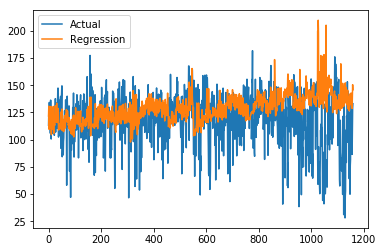

In [33]:
hdrvsa_=pd.concat([hdreal_,hdregress_], axis=1, sort=False)
hdrvsa_.columns=["Actual","Regression"]
print("Heat+Drought, Actual vs Regression Comparison")
hdplot_=hdrvsa_.plot()

In [34]:
#REMOVING Several variables due to multicolinearity and coefficients significance

trainhd_env=hd_env.loc[:400]
testhd_env=hd_env.loc[401:]
testhd_env=testhd_env[['ENV_ID','ENV_YIELD_MEAN','ENV_YIELD_STD','TMAX_AVG','TMAX_STD',
                            'TMIN_AVG','TMIN_STD','DAYL_AVG','DAYL_STD',
                           'SRAD_AVG','SRAD_STD','IRRIGATION','PREC_AVG','PREC_STD','KSAT',
                              'SWE_AVG','SWE_STD','VP_AVG','VP_STD','AWC']]


features_=['TMAX_AVG','TMAX_STD','TMIN_AVG','TMIN_STD',
                           'SRAD_AVG','PREC_AVG','SWE_AVG','VP_AVG']
X = trainhd_env[features_]
y = trainhd_env["ENV_YIELD_MEAN"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary2())

coeff_df=pd.DataFrame(model.params)
print(coeff_df)
tc=coeff_df.transpose()
tc.columns


                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.983    
Dependent Variable: ENV_YIELD_MEAN   AIC:                3283.8627
Date:               2018-12-01 19:19 BIC:                3315.8144
No. Observations:   401              Log-Likelihood:     -1633.9  
Df Model:           8                F-statistic:        2941.    
Df Residuals:       393              Prob (F-statistic): 0.00     
R-squared:          0.984            Scale:              206.76   
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
TMAX_AVG   -1.2471     1.2584   -0.9911   0.3223   -3.7211    1.2268
TMAX_STD    4.7847     2.0764    2.3043   0.0217    0.7025    8.8670
TMIN_AVG   14.5302     2.4790    5.8613   0.0000    9.6564   19.4040
TMIN_STD    6.7748     1.9859    3.4115   0.0007    2.8705   10.6791

Index(['TMAX_AVG', 'TMAX_STD', 'TMIN_AVG', 'TMIN_STD', 'SRAD_AVG', 'PREC_AVG',
       'SWE_AVG', 'VP_AVG'],
      dtype='object')

In [35]:
#Test coefficients with test data

coeff_=tc['TMAX_AVG']
testhd_env['TMAX_AVG']=testhd_env['TMAX_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['TMAX_STD']
testhd_env['TMAX_STD']=testhd_env['TMAX_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['TMIN_AVG']
testhd_env['TMIN_AVG']=testhd_env['TMIN_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['TMIN_STD']
testhd_env['TMIN_STD']=testhd_env['TMIN_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['SRAD_AVG']
testhd_env['SRAD_AVG']=testhd_env['SRAD_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['PREC_AVG']
testhd_env['PREC_AVG']=testhd_env['PREC_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['VP_AVG']
testhd_env['VP_AVG']=testhd_env['VP_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['SWE_AVG']

testhd_env['SWE_AVG']=testhd_env['SWE_AVG'].apply (lambda x: coeff_ * x )



testhdreg_env=testhd_env[['TMAX_AVG','TMAX_STD','TMIN_AVG','TMIN_STD',
                           'SRAD_AVG','PREC_AVG',
                              'SWE_AVG','VP_AVG']]


real_=testhd_env["ENV_YIELD_MEAN"]
regress_=[]
regress_=list(testhdreg_env.sum(1))
regress_=pd.DataFrame(regress_, columns=['YIELDREG'])
real_=pd.DataFrame(list(real_), columns=['YIELDREG'])

error_=(real_-regress_)**2

print('sqmeanerror',error_.mean()**0.5)
print('sqstderror',error_.std()**0.5)


sqmeanerror YIELDREG    30.688087
dtype: float64
sqstderror YIELDREG    46.097586
dtype: float64


### SQ Mean Error increased from previous iteration

## Trying regression with previously found coefficients for independent linear regressions

In [36]:
print(heat_coeff)
print(drought_coeff)

   TMAX_AVG  TMAX_STD  TMIN_AVG  TMIN_STD
0  2.103662  2.155283  5.732214  4.137954
   PREC_AVG  PREC_STD     KSAT       AWC
0 -3.461698  5.783615  3.56207  3.181174


In [37]:
#REMOVING KSAT due to high Pvalue

trainhd_env=hd_env.loc[:400]
testhd_env=hd_env.loc[401:]
testhd_env=testhd_env[['ENV_ID','ENV_YIELD_MEAN','ENV_YIELD_STD','TMAX_AVG','TMAX_STD',
                            'TMIN_AVG','TMIN_STD','DAYL_AVG','DAYL_STD',
                           'SRAD_AVG','SRAD_STD','IRRIGATION','PREC_AVG','PREC_STD','KSAT',
                              'SWE_AVG','SWE_STD','VP_AVG','VP_STD','AWC']]


features_=['TMAX_AVG','TMAX_STD','TMIN_AVG','TMIN_STD',
            'PREC_AVG','PREC_STD','KSAT','AWC']
X = trainhd_env[features_]
y = trainhd_env["ENV_YIELD_MEAN"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary2())

coeff_df=pd.DataFrame(model.params)
print(coeff_df)
tc=coeff_df.transpose()
tc.columns

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.982    
Dependent Variable: ENV_YIELD_MEAN   AIC:                3309.5541
Date:               2018-12-01 19:20 BIC:                3341.5058
No. Observations:   401              Log-Likelihood:     -1646.8  
Df Model:           8                F-statistic:        2756.    
Df Residuals:       393              Prob (F-statistic): 0.00     
R-squared:          0.982            Scale:              220.44   
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
TMAX_AVG    0.9601     0.7828    1.2265   0.2207   -0.5789    2.4991
TMAX_STD    1.5355     2.3476    0.6541   0.5134   -3.0799    6.1510
TMIN_AVG    6.8163     1.2481    5.4612   0.0000    4.3624    9.2701
TMIN_STD    4.0249     2.1233    1.8955   0.0588   -0.1496    8.1994

Index(['TMAX_AVG', 'TMAX_STD', 'TMIN_AVG', 'TMIN_STD', 'PREC_AVG', 'PREC_STD',
       'KSAT', 'AWC'],
      dtype='object')

In [38]:
#Test coefficients with test data

coeff_=tc['TMAX_AVG']
testhd_env['TMAX_AVG']=testhd_env['TMAX_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['TMAX_STD']
testhd_env['TMAX_STD']=testhd_env['TMAX_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['TMIN_AVG']
testhd_env['TMIN_AVG']=testhd_env['TMIN_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['TMIN_STD']
testhd_env['TMIN_STD']=testhd_env['TMIN_STD'].apply (lambda x: coeff_ * x )

coeff_=tc['PREC_AVG']
testhd_env['PREC_AVG']=testhd_env['PREC_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['PREC_STD']
testhd_env['PREC_STD']=testhd_env['PREC_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['KSAT']
testhd_env['KSAT']=testhd_env['KSAT'].apply (lambda x: coeff_ * x )
coeff_=tc['AWC']
testhd_env['AWC']=testhd_env['AWC'].apply (lambda x: coeff_ * x )




testhdreg_env=testhd_env[['TMAX_AVG','TMAX_STD','TMIN_AVG','TMIN_STD',
            'PREC_AVG','PREC_STD','KSAT','AWC']]


real_=testhd_env["ENV_YIELD_MEAN"]
regress_=[]
regress_=list(testhdreg_env.sum(1))
regress_=pd.DataFrame(regress_, columns=['YIELDREG'])
real_=pd.DataFrame(list(real_), columns=['YIELDREG'])

error_=(real_-regress_)**2

print('sqmeanerror',error_.mean()**0.5)
print('sqstderror',error_.std()**0.5)


sqmeanerror YIELDREG    38.562922
dtype: float64
sqstderror YIELDREG    59.162118
dtype: float64


### Sq Mean Error is signicantly higer from the best iteration found, therefore we would use the previous one

# Coefficients and Errors comparisons

In [39]:
print("Heat Variables + Coefficients")
print(heat_coeff)
print("Heat SqMeanError ->",float(heat_error_))
print(" ")
print(" ")
print("Drought Variables + Coefficients")
print(drought_coeff)
print("Drought SqMeanError ->",float(drought_sqerror_))
print(" ")
print(" ")
print("Heat&Drought Variables + Coefficients")
print(hd_coeff)
print("Heat+Drought SqMeanError ->",float(hd_sqerror_))

Heat Variables + Coefficients
   TMAX_AVG  TMAX_STD  TMIN_AVG  TMIN_STD
0  2.103662  2.155283  5.732214  4.137954
Heat SqMeanError -> 37.47336766241544
 
 
Drought Variables + Coefficients
   PREC_AVG  PREC_STD     KSAT       AWC
0 -3.461698  5.783615  3.56207  3.181174
Drought SqMeanError -> 26.160085806409413
 
 
Heat&Drought Variables + Coefficients
   TMAX_AVG  TMAX_STD   TMIN_AVG  TMIN_STD  SRAD_AVG  SRAD_STD  PREC_AVG  \
0 -1.453651  7.620979  14.118853  4.971993  0.214189 -0.238371  8.071271   

   PREC_STD   SWE_AVG   SWE_STD    VP_AVG    VP_STD  
0 -0.426228 -0.815425  0.485474 -0.102216 -0.016457  
Heat+Drought SqMeanError -> 29.819601260494142


### As it can be seen, the linear regression with the best error (less is better) is the one that only considers drought factors), in order to verify that, previous visualizations comparisons can help:

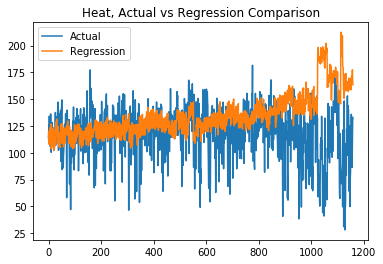

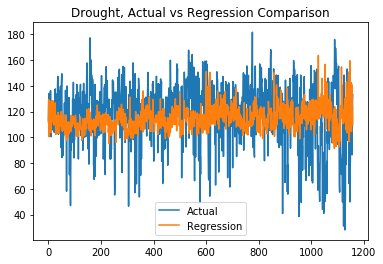

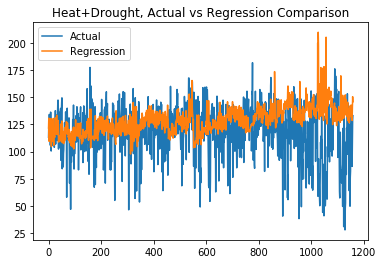

In [51]:
hrvsa_.plot(title='Heat, Actual vs Regression Comparison')
drvsa_.plot(title='Drought, Actual vs Regression Comparison')
hdrvsa_.plot(title='Heat+Drought, Actual vs Regression Comparison')

# Drought Regression is the best fit and is consistent with the measured sqMeanError, however, we can see that there are certain data points that cannot be accurate predicted and therefore we decided to build more complex models with other methods